# SpikeLab - Watershed challenge

Gabriel Delgado
27/06/2022

In [1]:
import pandas as pd
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import lightgbm as lgb

In [2]:
df = pd.read_csv("flux.csv", usecols=['date', 'basin_id', 'flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2'])

In [3]:
df.head()

,date,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,-18.0769,-69.1961,4842.449328,49.711859


## 2. Perform an EDA over flux.csv file.

A few observations of the data

* Data ranges from 1980 to 2020
* There are more than 4M registers
* 503 different watersheds
* The variables precip and temp_max present 5443 missing values
* Numerical variable max and min values seem to be OK (flux, precip >=0 and -12 < temperature < 40)

In [11]:
df['date'].min()

'1980-01-01'

In [12]:
df['date'].max()

'2020-04-30'

In [6]:
df.shape

(4180480, 9)

In [6]:
# precip and temp_max have missing values
df[['flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2']].describe()

,flux,precip,temp_max,lat,lon,mean_elev,area_km2
count,4.180480e+06,4.175037e+06,4.175037e+06,4.180480e+06,4.180480e+06,4.180480e+06,4.180480e+06
mean,5.253340e+01,2.947445e+00,1.365728e+01,-3.569572e+01,-7.129595e+01,1.760129e+03,2.404876e+03
std,1.676027e+02,8.766749e+00,6.615037e+00,8.047659e+00,1.254339e+00,1.382121e+03,4.322051e+03
min,0.000000e+00,0.000000e+00,-1.160359e+01,-5.494690e+01,-7.366670e+01,1.181229e+02,1.789123e+01
25%,8.680000e-01,0.000000e+00,9.162867e+00,-3.915000e+01,-7.231670e+01,5.847012e+02,3.761001e+02
50%,5.171000e+00,0.000000e+00,1.321396e+01,-3.588420e+01,-7.137190e+01,1.195311e+03,8.205541e+02
75%,2.990000e+01,6.422626e-01,1.805745e+01,-3.126560e+01,-7.050670e+01,3.048161e+03,2.461610e+03
max,1.580500e+04,2.132120e+02,4.081117e+01,-1.784280e+01,-6.763920e+01,4.910152e+03,5.224367e+04


In [8]:
df['basin_id'].value_counts()

5410002     14670
10134001    14649
4703002     14639
4320001     14634
9129002     14603
            ...  
6034001       328
8117001       302
5423002       195
4534001       195
10683002      175
Name: basin_id, Length: 503, dtype: int64

In [7]:
df.isnull().sum()

date            0
basin_id        0
flux            0
precip       5443
temp_max     5443
lat             0
lon             0
mean_elev       0
area_km2        0
dtype: int64

In [8]:
df.dropna(inplace=True)

## 3.Plot flux, temperature and precipitations:

In [13]:
def get_timeseries(cod_station, variable, min_date, max_date, data=df):
    
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
    df_one_timeseries = data[(data['basin_id'] == cod_station) & 
                             (data['date'] >= min_date) & 
                             (data['date'] <= max_date)][['date', *variable]]
    df_one_timeseries = df_one_timeseries.set_index('date').sort_index()
    
    return df_one_timeseries


def plot_one_timeserie(cod_station, variable, min_date, max_date):
    
    df_one_timeseries = get_timeseries(cod_station, [variable], min_date, max_date)
    df_one_timeseries.plot(figsize=(10, 5))


def plot_three_timeseries(cod_station, min_date, max_date):
    
    df_three_timeseries = get_timeseries(cod_station, ['flux', 'temp_max', 'precip'], min_date, max_date)
    df_three_timeseries = (df_three_timeseries - df_three_timeseries.min()) / (df_three_timeseries.max() - df_three_timeseries.min())
    df_three_timeseries.plot(figsize=(20, 10))
    
    return None

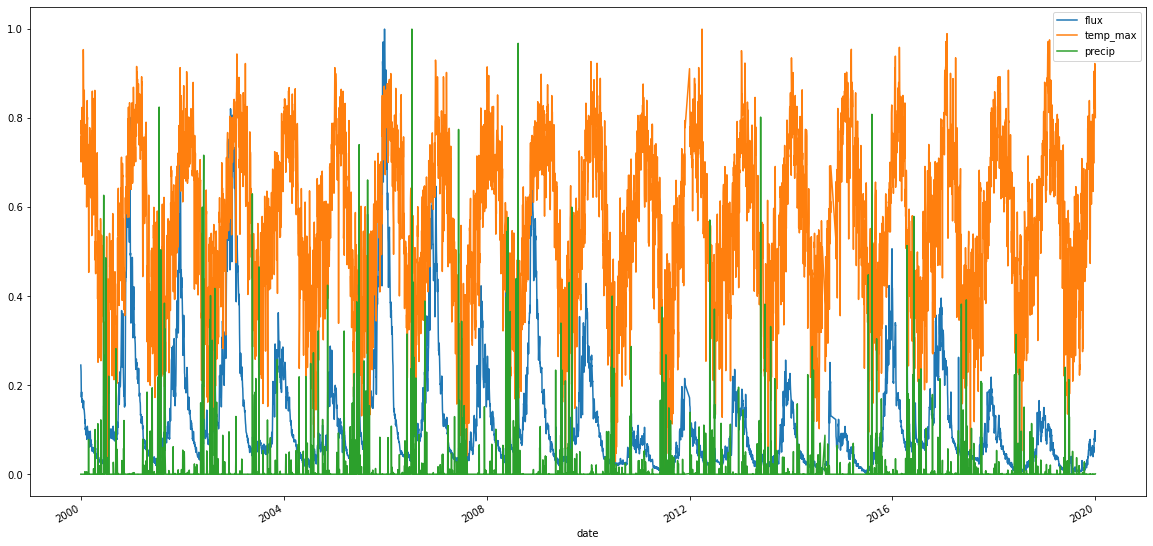

In [14]:
# Example of plotting function

plot_three_timeseries(5410002, '2000-01-01', '2020-01-01')

## 4. Create three variables called: flux_extreme, temp_extreme, precip_extreme

After reading a few articles on the subject https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012GL053361, https://www.webofscience.com/wos/woscc/full-record/WOS:000278134100014?SID=EUW1ED0F52EtSrmsEWvnzL5c117hd, https://link.springer.com/article/10.1007/s00704-020-03166-8#Tab1,
there seem to exist different methods to capture extreme events. One of them is the use of relative thresholds based on percentiles. This approach has the advantage of ensuring observations to be extreme by definition and the possibility of comparing results obtained in geographic areas with a different climate and also in different seasons of the year.
Limitations with respect to absolute threshold (which may be related to impacts) include the fact that the frequency of occurrence is assumed to be known (if we have few data then it is difficult to get a robust threshold) and that extremes that are so identified are not necessarily “extreme” because of their impact.

Based on that, here we compute the relative thresholds for a 95% percentile over a baseline period of 30 years (1980 - 2010) and then we analyze the evolution of occurrence of extreme events over the period 2010 - 2020. The percentiles are computed for each month. Hence an event will be considered extreme for example the 05/03/2019 if the variable value is larger than the 95% percentile of all the months of March between 1980 and 2010.  

As an improvement of this method, I would propose the use of percentiles for each calendar day separately using an x-day-window-centered method instead of monthly percentiles. 
Indeed this could better capture the extreme event threshold for the beginning and end of a certain month.

In [15]:
min_control = '1980-01-01'
max_control = '2010-01-01'

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df_control = df[(df['date'] >= min_control) & (df['date'] <= max_control)]

In [16]:
extreme_values = (
    df_control
    .groupby(['month', 'basin_id'])[['flux', 'temp_max', 'precip']]
    .agg(lambda values: np.percentile(values, 95))
)

In [17]:
tuples_month_basin_id = list(zip(df['month'], df['basin_id']))
array_month_basin_id = np.empty(len(tuples_month_basin_id), dtype=object)
array_month_basin_id[:] = tuples_month_basin_id

In [18]:
df['flux_extreme'] = 1 * (df['flux'] > extreme_values['flux'][array_month_basin_id].values)
df['temp_extreme'] = 1 * (df['temp_max'] > extreme_values['temp_max'][array_month_basin_id].values)
df['precip_extreme'] = 1 * (df['precip'] > extreme_values['precip'][array_month_basin_id].values)

In [19]:
df.head(2)

,date,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2,month,year,flux_extreme,temp_extreme,precip_extreme
0,1980-01-01,1001001,0.579,0.0,10.685653,-18.0769,-69.1961,4842.449328,49.711859,1,1980,0,0,0
1,1980-01-02,1001001,0.543,0.0,11.470960,-18.0769,-69.1961,4842.449328,49.711859,1,1980,0,0,0


## 5. Plot the variable flux_extreme. Are there any different behaviours among different watersheds?

From the boxplot we see that there are a few watersheds with a very high percentage of extreme flux events over the last 10 years, which make them quite different with respect to the rest.
These watersheds seem to be rather located in the extreme north and center of Chile.

In [33]:
perc_extreme_events = (
    df[df['date'] > max_control]
    .groupby(['basin_id', 'lat', 'lon'])[['flux_extreme']]
    .mean()
    .reset_index()
)

Text(0, 0.5, 'Last 10 years percentage of daily extreme events per watershed')

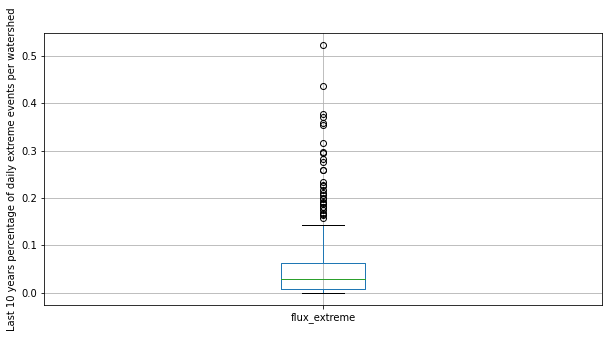

In [26]:
perc_extreme_events.boxplot(column=['flux_extreme'], figsize=(10, 5))
plt.ylabel('Last 10 years percentage of daily extreme events per watershed')

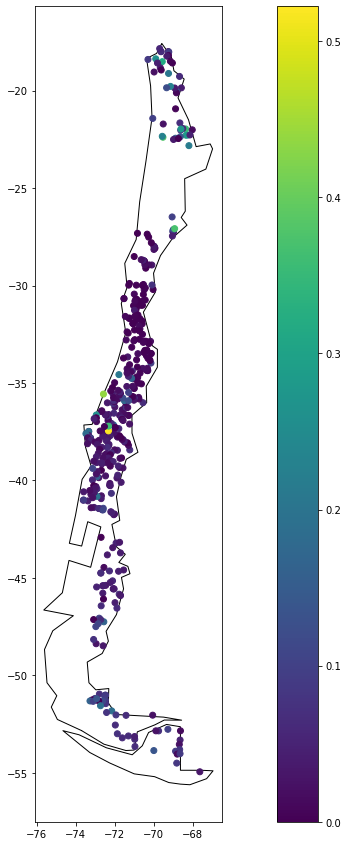

In [27]:
import geopandas

gdf = geopandas.GeoDataFrame(
    perc_extreme_events, geometry=geopandas.points_from_xy(perc_extreme_events.lon, perc_extreme_events.lat))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'Chile'].plot(
    color='white', edgecolor='black', figsize=(20, 15))

gdf.plot(ax=ax, column='flux_extreme', legend=True)

plt.show()

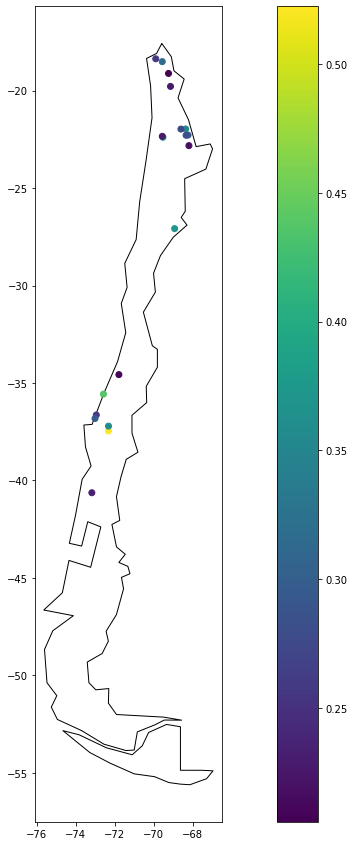

In [35]:
perc_extreme_events = perc_extreme_events[perc_extreme_events['flux_extreme'] > 0.2]

gdf = geopandas.GeoDataFrame(
    perc_extreme_events, geometry=geopandas.points_from_xy(perc_extreme_events.lon, perc_extreme_events.lat))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'Chile'].plot(
    color='white', edgecolor='black', figsize=(20, 15))

gdf.plot(ax=ax, column='flux_extreme', legend=True)

plt.show()

## 6. Plot the percentage of extreme events during time. Have they become more frequent?

Indeed, we remark in average over all the watersheds that extreme heat waves (extreme temperature) have become more frequent over the last years with respect to the
baseline 1980 - 2010. On the other side extreme flux and precipitations tend to slightly reduce over the years.

In [36]:
perc_extreme_events = (
    df[df['date'] > max_control]
    .groupby(['year'])[['flux_extreme', 'temp_extreme', 'precip_extreme']]
    .mean()
    .reset_index()
)
perc_extreme_events['date'] = pd.to_datetime(perc_extreme_events['year'], format='%Y')

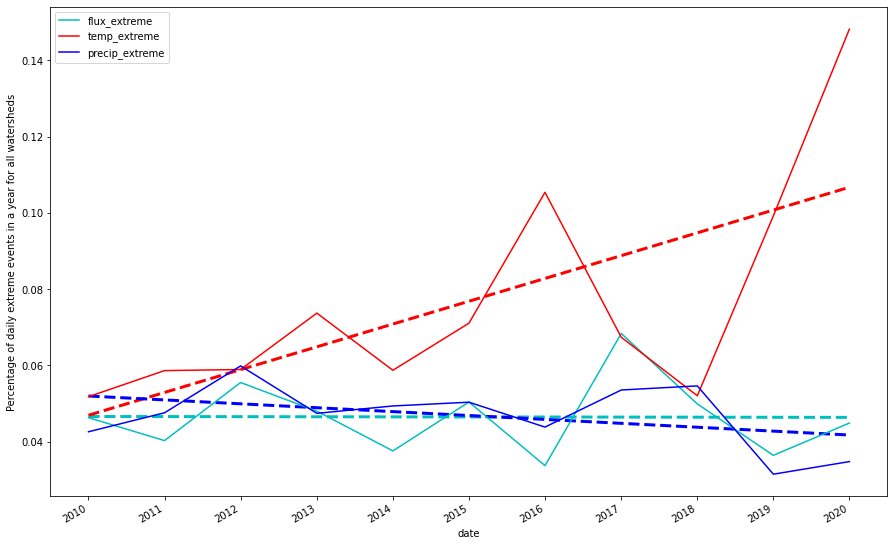

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))

x = perc_extreme_events['year']

z = np.polyfit(x, perc_extreme_events["flux_extreme"], 1)
p = np.poly1d(z)
plt.plot(perc_extreme_events['date'], p(x), color="c", linewidth=3, linestyle="--")

z = np.polyfit(x, perc_extreme_events["temp_extreme"], 1)
p = np.poly1d(z)
plt.plot(perc_extreme_events['date'], p(x), color="r", linewidth=3, linestyle="--")

z = np.polyfit(x, perc_extreme_events["precip_extreme"], 1)
p = np.poly1d(z)
plt.plot(perc_extreme_events['date'], p(x), color="b", linewidth=3, linestyle="--")

plt.ylabel('Percentage of daily extreme events in a year for all watersheds')

perc_extreme_events.plot(x="date", y=["flux_extreme", "temp_extreme", "precip_extreme"], color=['c', 'r', 'b'], ax=ax)
plt.show()

## 7. Extreme flux prediction. 

### Train one or many models (using your preferred algorithms) for estimating the probability of having an extreme flux. Feel free to create new features or use external variables. Some of the discussion we would like to see: Which data can be used and which cannot? Of course, we cannot use future data, but what about data from the same day? Or from the previous day?

In this section we train two classification models to predict the next day probability of having an extreme flux. Once trained, we propose this model to be ran every 24h at the end of every day. This is coherent with the way the aggregated features (flux, precip and temp_max) were built. Because of temporal reasons one cannot use same day flow event data.

That being said, another usage possibility of this model would have been to continuously run it within the day to predict a same day extreme flux event. This approach has the advantage of using previous day and same day data. However the model feature update, monitoring and industrialization is more complex.

To train these models, we use the data between 1980 and 2010. As test we consider the data from 2010 to 2020. Here below the features used to create the models:

* The watershed previous day flux, precip and temp_max. 
* Last 5 previous days mean, max and min of the watershed temp_max, flux and precip.
* The previous day extreme event of flux, temp and precip.
* A periodic transformation of the date month.
* The year.
* The watershed (lat, lon) coordintates.
* The watershed mean_elev 
* The watershed area_km2

Other ideas of features that I didn't have the time to code could be:

* Part of the month of the date (for example first half or second half). 
* Last N previous days mean, max and min of the closest watersheds temp_max, flux and precip.
* Local atmospheric pressure and relative humidity.

In [38]:
df = df.sort_values(by=['basin_id', 'date']).set_index('date')

In [39]:
df_mean = df.groupby('basin_id')[['flux', 'temp_max', 'precip']].rolling(5).mean()
df_mean = df_mean.rename(columns={"flux": "rolling_mean_flux", "temp_max": "rolling_mean_temp_max", "precip": "rolling_mean_precip"})
df_mean.dropna(axis=0, inplace=True)

In [40]:
df_max = df.groupby('basin_id')[['flux', 'temp_max', 'precip']].rolling(5).max()
df_max = df_max.rename(columns={"flux": "rolling_max_flux", "temp_max": "rolling_max_temp_max", "precip": "rolling_max_precip"})
df_max.dropna(axis=0, inplace=True)

In [41]:
df_min = df.groupby('basin_id')[['flux', 'temp_max', 'precip']].rolling(5).min()
df_min = df_min.rename(columns={"flux": "rolling_min_flux", "temp_max": "rolling_min_temp_max", "precip": "rolling_min_precip"})
df_min.dropna(axis=0, inplace=True)

In [42]:
df = df.merge(df_min, on=['basin_id', 'date'])
df = df.merge(df_max, on=['basin_id', 'date'])
df = df.merge(df_mean, on=['basin_id', 'date'])

In [43]:
# We shift the target to avoid using future data
df_target = df[['basin_id', 'flux_extreme']]
df_target.index = df_target.index.shift(-1, freq='D')
df_target = df_target.rename(columns={"flux_extreme": "target_flux_extreme"})

In [44]:
df = df.merge(df_target, on=['basin_id', 'date'])

In [45]:
df['periodic_month'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

In [46]:
# Computing df.corr(), we remove features with higher correlation of 0.9, in particular:
#'flux' -> 'rolling_min_flux', 'rolling_mean_flux', 'rolling_mean_flux '
#'temp_max' -> 'rolling_min_temp_max', 'rolling_mean_temp_max', 'rolling_max_temp_max'

features = ['flux', 'precip', 'temp_max', 'lat', 'lon', 'mean_elev', 'area_km2', 'periodic_month', 'year', 
            'flux_extreme', 'temp_extreme', 'precip_extreme', 
            'rolling_min_precip', 'rolling_mean_precip']

target = ['target_flux_extreme']

In [47]:
X_train = df[(df.index >= min_control) & (df.index <= max_control)][features]
y_train = df[(df.index >= min_control) & (df.index <= max_control)][target]

X_test = df[(df.index > max_control)][features]
y_test = df[(df.index > max_control)][target]

In [48]:
X_train.head(2)

,flux,precip,temp_max,lat,lon,mean_elev,area_km2,periodic_month,year,flux_extreme,temp_extreme,precip_extreme,rolling_min_precip,rolling_mean_precip
date,,,,,,,,,,,,,,
1980-01-05,0.436,0.0,12.649203,-18.0769,-69.1961,4842.449328,49.711859,1.0,1980,0,1,0,0.0,0.0
1980-01-06,0.385,0.0,12.798975,-18.0769,-69.1961,4842.449328,49.711859,1.0,1980,0,1,0,0.0,0.0


### Logistic regression

In [49]:
lg = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(class_weight='balanced'))])
lg.fit(X_train, y_train)

print("--------Train results--------")
print(classification_report(y_train, lg.predict(X_train)))

print("--------Test results--------")
print(classification_report(y_test, lg.predict(X_test)))

/home/gabriel.delgado/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


--------Train results--------
              precision    recall  f1-score   support

           0       0.99      0.96      0.97   2805726
           1       0.52      0.85      0.64    147241

    accuracy                           0.95   2952967
   macro avg       0.75      0.90      0.81   2952967
weighted avg       0.97      0.95      0.96   2952967

--------Test results--------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98   1148676
           1       0.55      0.89      0.68     56247

    accuracy                           0.96   1204923
   macro avg       0.77      0.93      0.83   1204923
weighted avg       0.97      0.96      0.97   1204923



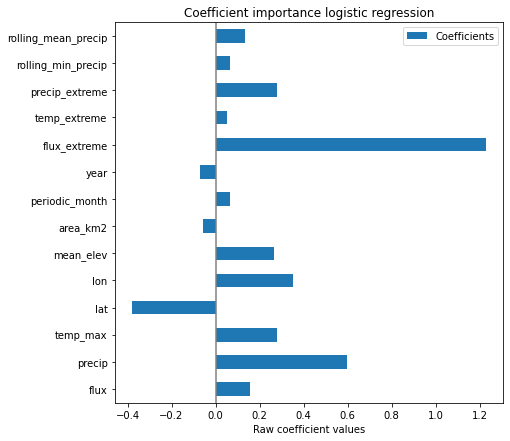

In [50]:
coefs = pd.DataFrame(
    lg[-1].coef_.transpose(),
    columns=["Coefficients"],
    index=features,
)

coefs.plot.barh(figsize=(9, 7))
plt.title("Coefficient importance logistic regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

### LightGBM

In [51]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

print("--------Train results--------")
print(classification_report(y_train, clf.predict(X_train)))

print("--------Test results--------")
print(classification_report(y_test, clf.predict(X_test)))

/home/gabriel.delgado/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


--------Train results--------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   2805726
           1       0.77      0.74      0.75    147241

    accuracy                           0.98   2952967
   macro avg       0.88      0.86      0.87   2952967
weighted avg       0.98      0.98      0.98   2952967

--------Test results--------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1148676
           1       0.76      0.77      0.76     56247

    accuracy                           0.98   1204923
   macro avg       0.87      0.88      0.88   1204923
weighted avg       0.98      0.98      0.98   1204923



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

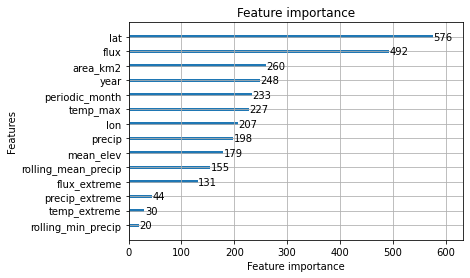

In [52]:
lgb.plot_importance(clf)

## 8. Analyze model results

### a) What is the performance of the model? Which metrics you consider are the best suited for this problem? What are the most important variables? What do you think about the results?

Since this is a classification problem, the best suited metrics are precision, recall, f1 score and AUC ROC. 
Two models where trained and tested, both presenting good results (high f1 score and no overfitting). The only point of attention is that the scores seem to be slightly
better on the test set instead of the train set. I would say that this is because the data distribition is not the same between both datasets due to time evolution.


* **LightGBM model**. F1 score of 0.75. The most important features are the watershed's latitude and previous day flux. 

* **Logistic regression model**. F1 score of 0.68. For this model the data must be beforehand standardized and a class weight applied to compensate class unbalance (by definition we try to predict extreme events). The advantage of the logistic regression is the interpretability of the features importance following the sign and magnitude of the feature coefficients: 

a) The features previous day flux_extreme, precipitation and temp_max have the highest positive impact on the probability of an extreme flux event. This can be understood as "if the previous day an extreme flux event or a higher precipitation or a higher temperature happen, then its more likely today to have an extreme flux event". With lower magnitude we also remark that extreme flux events are more likely to happen on watersheds with higher elevation and closer to the Andes Mountains (higher longitude value).

b) The features latitude and year have a negative impact on the probability of an extreme flux event. Indeed, as shown in section 6. the number of days over a year showing extreme flow events tend to reduce every year (probably because of drought issues) and extreme flux events occur more often over the last 10 years in the south of Chile (lower latitude), probably because it rains more than in the north of Chile (Atacama desert).



### b) If we wanted to identify at least 70% of the extreme flux events, which are the metrics of your model for that threshold? It is a useful model?

The right metric would be to fix the model's recall (ratio between the correct positive events predicted divided by the total number of positive events) to be higher than 70%. As we can see, the LightGBM model scores a recall > 0.7 without penalizing the precision (also above 0.7). This is an useful model because is sensible enought to detect extreme flux events while remaining precise (i.e. avoiding false positives).
